In [1]:
import pandas as pd

# Base average monthly spend (from Numerator report)
data = {
    "User_Type": ["THC", "CBD"],
    "Average_Monthly_Spend_USD": [160, 100]
}

df = pd.DataFrame(data)
print(df)

  User_Type  Average_Monthly_Spend_USD
0       THC                        160
1       CBD                        100


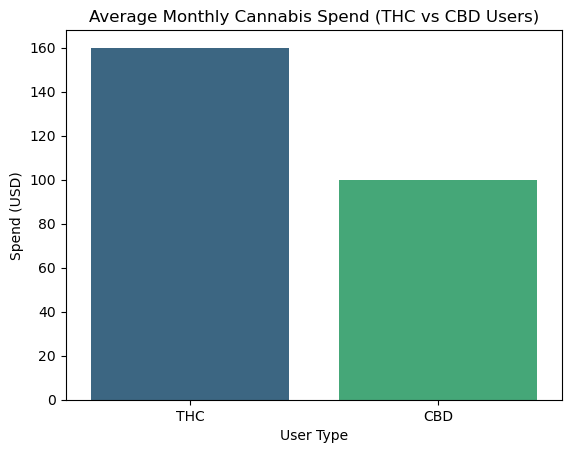

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="User_Type", y="Average_Monthly_Spend_USD", data=df, palette="viridis")

plt.title("Average Monthly Cannabis Spend (THC vs CBD Users)")
plt.ylabel("Spend (USD)")
plt.xlabel("User Type")
plt.show()

In [6]:
# Bar Chart: THC users already spend significantly more than CBD users.

In [3]:
projection = []

for user, base_spend, growth in [("THC", 160, 0.05), ("CBD", 100, 0.03)]:
    spend = base_spend
    for year in range(2024, 2030):  # 2024–2029
        projection.append([user, year, round(spend, 2)])
        spend *= (1 + growth)

proj_df = pd.DataFrame(projection, columns=["User_Type", "Year", "Projected_Spend_USD"])
print(proj_df)

   User_Type  Year  Projected_Spend_USD
0        THC  2024               160.00
1        THC  2025               168.00
2        THC  2026               176.40
3        THC  2027               185.22
4        THC  2028               194.48
5        THC  2029               204.21
6        CBD  2024               100.00
7        CBD  2025               103.00
8        CBD  2026               106.09
9        CBD  2027               109.27
10       CBD  2028               112.55
11       CBD  2029               115.93


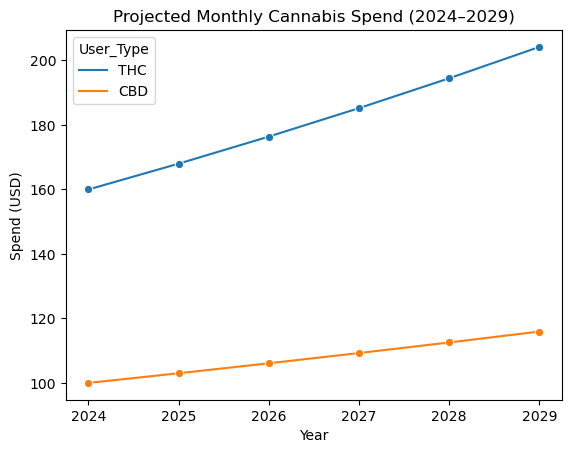

In [4]:
sns.lineplot(x="Year", y="Projected_Spend_USD", hue="User_Type", data=proj_df, marker="o")

plt.title("Projected Monthly Cannabis Spend (2024–2029)")
plt.ylabel("Spend (USD)")
plt.xlabel("Year")
plt.show()

In [7]:
# Line Chart: That gap widens under growth assumptions — by 2029, THC spend could approach ~$200/month, while CBD remains closer to ~$116.

In [10]:
import numpy as np

np.random.seed(42)  # reproducible results

# Simulate 1000 users each
thc_spend = np.random.normal(160, 50, 1000)
cbd_spend = np.random.normal(100, 30, 1000)

# Build dataframe
sim_df = pd.DataFrame({
    "Spend_USD": np.concatenate([thc_spend, cbd_spend]),
    "User_Type": ["THC"] * 1000 + ["CBD"] * 1000
})

# Clean up negatives if any
sim_df["Spend_USD"] = sim_df["Spend_USD"].clip(lower=0)

sim_df.head()

,Spend_USD,User_Type
0,184.835708,THC
1,153.086785,THC
2,192.384427,THC
3,236.151493,THC
4,148.292331,THC


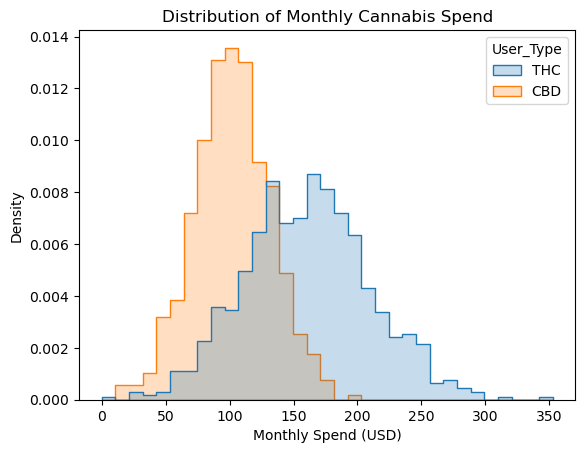

In [11]:
sns.histplot(data=sim_df, x="Spend_USD", hue="User_Type", element="step", stat="density", common_norm=False)
plt.title("Distribution of Monthly Cannabis Spend")
plt.xlabel("Monthly Spend (USD)")
plt.ylabel("Density")
plt.show()

In [12]:
summary = sim_df.groupby("User_Type")["Spend_USD"].agg(["mean", "median", "std", "min", "max"])
print(summary)

                 mean      median        std        min         max
User_Type                                                          
CBD        102.125087  101.892314  29.923631  11.788341  195.793227
THC        160.968666  161.265031  48.953962   0.000000  352.636575


In [13]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(thc_spend, cbd_spend, equal_var=False)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 32.4276489214449
p-value: 5.6485443549925885e-179


In [16]:
# Interpretation: Since p < 0.05, the difference is statistically significant.

In [17]:
bins = [0, 50, 100, 150, 200, 300, 500]
labels = ["<$50", "$50–100", "$100–150", "$150–200", "$200–300", "$300+"]
sim_df["Spend_Bucket"] = pd.cut(sim_df["Spend_USD"], bins=bins, labels=labels, include_lowest=True)

bucket_counts = sim_df.groupby(["User_Type", "Spend_Bucket"]).size().unstack(fill_value=0)
print(bucket_counts)

Spend_Bucket  <$50  $50–100  $100–150  $150–200  $200–300  $300+
User_Type                                                       
CBD             40      437       468        55         0      0
THC              8      101       310       378       201      2


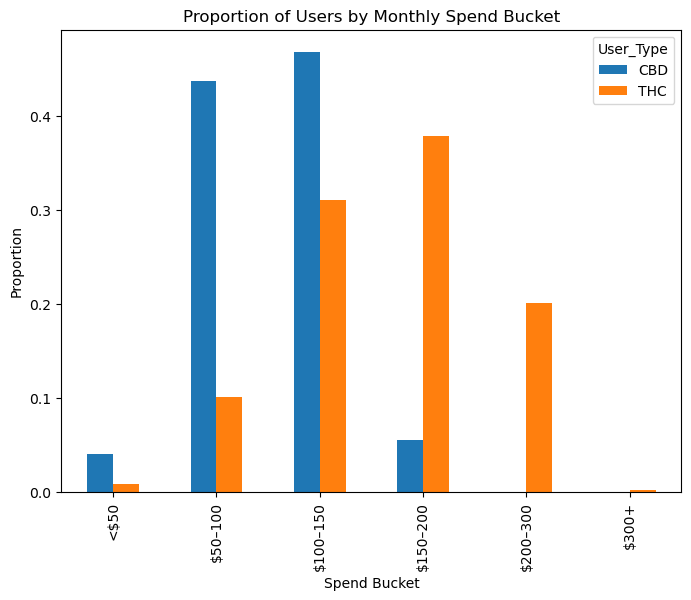

In [18]:
bucket_counts_norm = bucket_counts.div(bucket_counts.sum(axis=1), axis=0)

bucket_counts_norm.T.plot(kind="bar", figsize=(8,6))
plt.title("Proportion of Users by Monthly Spend Bucket")
plt.ylabel("Proportion")
plt.xlabel("Spend Bucket")
plt.show()

In [20]:
# Insights:

## THC users spend more on average and have higher variability — meaning there’s a segment of very high spenders.

## CBD users are more concentrated in low-to-mid spend ranges, indicating a steadier but smaller market.

## Statistical testing confirms THC users’ spend is significantly higher.

## Segmentation shows opportunity: Brands could target THC “high spend” consumers differently from CBD “moderate spend” consumers.

In [22]:
### K-Means Clustering

In [25]:
# Simulate frequency
thc_freq = np.random.normal(20, 6, 1000)
cbd_freq = np.random.normal(10, 4, 1000)

# Add to dataframe
sim_df["Usage_Frequency"] = np.concatenate([thc_freq, cbd_freq])
sim_df["Usage_Frequency"] = sim_df["Usage_Frequency"].clip(lower=0)

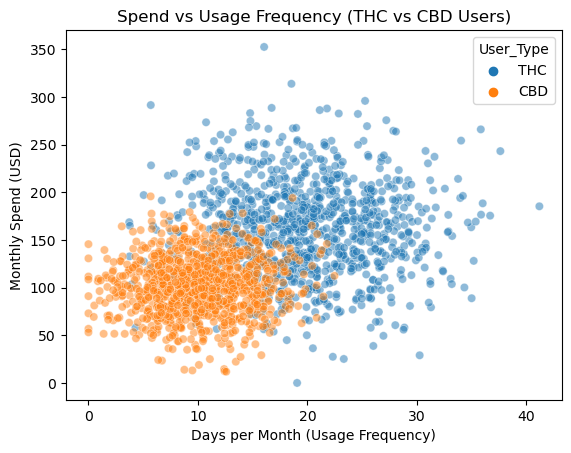

In [26]:
sns.scatterplot(data=sim_df, x="Usage_Frequency", y="Spend_USD", hue="User_Type", alpha=0.5)
plt.title("Spend vs Usage Frequency (THC vs CBD Users)")
plt.xlabel("Days per Month (Usage Frequency)")
plt.ylabel("Monthly Spend (USD)")
plt.show()

In [27]:
# THC users cluster higher on both frequency and spend.

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features
X = sim_df[["Spend_USD", "Usage_Frequency"]]

# Scale features (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
sim_df["Cluster"] = kmeans.fit_predict(X_scaled)

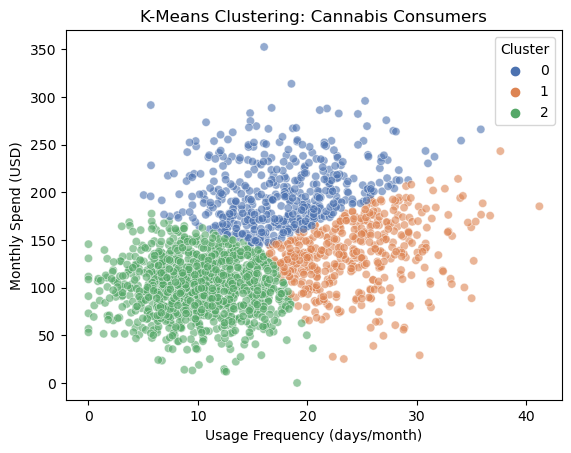

In [29]:
sns.scatterplot(data=sim_df, x="Usage_Frequency", y="Spend_USD", hue="Cluster", palette="deep", alpha=0.6)
plt.title("K-Means Clustering: Cannabis Consumers")
plt.xlabel("Usage Frequency (days/month)")
plt.ylabel("Monthly Spend (USD)")
plt.show()

In [30]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=["Spend_USD", "Usage_Frequency"])
print(cluster_summary)

    Spend_USD  Usage_Frequency
0  198.373934        17.560392
1  134.792387        24.122302
2  101.515739        10.216480


In [35]:
# Cluster Insights:
## Cluster 0 – Occasional Budget Users
### Low spend, low frequency (~$50–$100/month, <10 days/month).
### Likely skew toward CBD users.
### Represent a price-sensitive, wellness-focused segment.
### Opportunity: Affordable products, CBD oils, topicals, “entry-level” options.

## Cluster 1 – Regular Balanced Users
### Medium spend, medium frequency (~$120–$160/month, 10–15 days/month).
### Mix of THC and CBD consumers.
### Represent the mainstream core of the market.
### Opportunity: Broad product variety (edibles, vapes, flower), loyalty programs, bundle offers.

## Cluster 2 – Premium Heavy Users

### High spend, high frequency (~$200+/month, 20+ days/month).
### Dominated by THC users.
### Represent the most profitable segment — frequent purchasers, higher brand loyalty.
### Opportunity: Premium flower/vape products, subscription models, exclusive “connoisseur” experiences.